In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import networkx as nx 
from matplotlib import pyplot as plt

# Turning dataframe into weighted graph

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/yuhsin-huang/Math168Project/main/reddit_data.csv")


In [5]:
df.head()

,ID,Date_utc,Author,Body,Submission,Parent_ID,Parent_Author,Level,Subreddit,Submission_Author,Submission_Title
0,hb5o5xe,1.630477e+09,krusty3x,This alone should put him In the chair.,pfnoiq,pfnoiq,8uwotm8,1,trueantivaccination,8uwotm8,Fauci-run NIAID spends almost $500k to run cru...
1,hb5tb0n,1.630481e+09,8uwotm8,nah he and his cumstains evil f4scists should ...,pfnoiq,hb5o5xe,krusty3x,2,trueantivaccination,8uwotm8,Fauci-run NIAID spends almost $500k to run cru...
2,hb88isn,1.630526e+09,SerScronzarelli,Grasping for straws aren't you?,pfmh8q,pfmh8q,Revolutionary-Comb35,1,trueantivaccination,Revolutionary-Comb35,Was this young lady a recent recipient of a vax?
3,hb9cje6,1.630545e+09,Revolutionary-Comb35,Inquiring minds want to know; \r\n\r\nwhat IF ...,pfmh8q,hb88isn,SerScronzarelli,2,trueantivaccination,Revolutionary-Comb35,Was this young lady a recent recipient of a vax?
4,hdndp6o,1.632178e+09,Revolutionary-Comb35,Have you change your tune about my inquiry now...,pfmh8q,hb88isn,SerScronzarelli,2,trueantivaccination,Revolutionary-Comb35,Was this young lady a recent recipient of a vax?


In [ ]:

G = nx.from_pandas_edgelist(df, create_using = nx.MultiGraph, source = "Author", target = "Parent_Author", 
                            edge_attr = ["ID", "Body","Date_utc","Level","Subreddit", "Submission_Title"])

In [ ]:
WG = nx.Graph()
for u,v,data in G.edges(data=True):
    w = data['weight'] if 'weight' in data else 1.0
    if WG.has_edge(u,v):
        WG[u][v]['weight'] += w
    else:
        WG.add_edge(u, v, weight=w)
        
    WG[u][v]['ID'] = data['ID']
    WG[u][v]['Body'] = data['Body']
    WG[u][v]['Level'] = data['Level']
    WG[u][v]['Subreddit'] = data['Subreddit']
    WG[u][v]['Date_utc'] = data["Date_utc"]
    WG[u][v]['Submission_Title'] = data['Submission_Title']

In [ ]:
#nx.write_gml(WG, '/content/gdrive/My Drive/Colab Notebooks/reddit_graphs/reddit_graph.gml')

# Splitting into subgraphs by date

In [ ]:
# start_time = 1628640000
# s = 86400
# count = 0
# for i in range(21):
#   selected_edges = [(u,v) for u,v,e in WG.edges(data=True) if e['Date_utc'] >= (start_time+s*i) and e['Date_utc'] <= (start_time + s*(i+1))]
#   newG = WG.edge_subgraph(selected_edges)
#   nx.write_gml(newG, f'/content/gdrive/My Drive/Colab Notebooks/reddit_graphs/aug_{i+11}.gml')
#   count += 1

# Data graphing and stuff?

In [3]:
G = nx.read_gml("reddit_graph_v2.gml")

Text(0.5, 0, 'Degree')

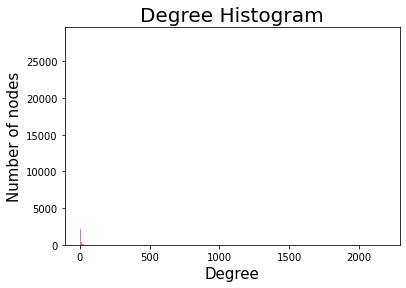

In [ ]:
degree_sequence = [G.degree(node, weight = "weight") for node in G.nodes()]
degree_sequence = np.array(degree_sequence)
degree_list, counts = np.unique(degree_sequence, return_counts=True)
avg_degree = np.mean(degree_sequence) 

fig, ax = plt.subplots()
ax.bar(degree_list, counts, color = "orchid")
ax.set_title('Degree Histogram', fontsize = 20)
ax.set_ylabel('Number of nodes', fontsize=15)
ax.set_xlabel("Degree", fontsize=15)

In [ ]:
degrees = list(dict(G.degree(weight = "weight")).items())
degrees.sort(reverse = True, key = lambda x:x[1])

In [ ]:
degree_df = pd.DataFrame(degrees, columns = ['user', 'degree'])

In [ ]:
degree_df.groupby('degree').count()

,user
degree,
1.0,28216
2.0,9944
3.0,5026
4.0,3140
5.0,2118
...,...
977.0,1
1002.0,1
1083.0,1


In [ ]:
component = max(nx.connected_components(G), key = len)
largest_C = G.subgraph(component)

In [ ]:
largest_C.number_of_nodes()

57902

In [ ]:
G.number_of_nodes()

58476

In [ ]:
#nx.write_gml(largest_C, r'/content/gdrive/MyDrive/reddit_graphs (1)/reddit_vis.gml')

# splitting into communities

In [116]:
# remove really small connected components
for component in list(nx.connected_components(G)):
    if len(component)<7:
        for node in component:
            G.remove_node(node)

In [12]:
mod = nx.algorithms.community.modularity(G, comms)
mod

0.6689937584985899

## diy communities

In [101]:
def get_modularity(G):
    top_sub = {}
    for node in G.nodes:
        subs = {}
        for source, target in list(G.edges(node)):
            subreddit = G[source][target]["Subreddit"]
            subs[subreddit] = subs.get(subreddit, 0) + G[source][target]["weight"]
        top_sub[node] = max(subs, key=subs.get)

    #nx.set_node_attributes(G, top_sub, "Top_Sub")

    diy_comms_dict = {'trueantivaccination':set(),
                     'vaccines': set(),
                     'covidvaccine':set(),
                     'covidvaccinated':set(),
                     'antivaxxers':set(),
                     'conspiracy':set(),
                     'conspiracytheories':set(),
                     'conspiracy_commons':set(),
                     'covid19':set(),
                     'coronavirus':set(),
                     'conservative':set(),
                     'news':set()}

    for user, sub in top_sub.items():
        diy_comms_dict[sub].add(user)

    diy_comms = list(diy_comms_dict.values())
    louvain = nx.community.louvain_communities(G, resolution = 1)
    
    return (nx.algorithms.community.modularity(G, diy_comms), nx.algorithms.community.modularity(G, louvain))

In [102]:
daily_mod = []
start_time = 1628640000
s = 86400
count = 0
for i in range(21):
    selected_edges = [(u,v) for u,v,e in G.edges(data=True) if e['Date_utc'] >= (start_time+s*i) and e['Date_utc'] <= (start_time + s*(i+1))]
    newG = G.edge_subgraph(selected_edges) 
    daily_mod.append(get_modularity(newG))

In [103]:
days = np.arange(11,32)
diy_mod, louvain_mod = list(zip(*daily_mod))

(0.6, 1.0)

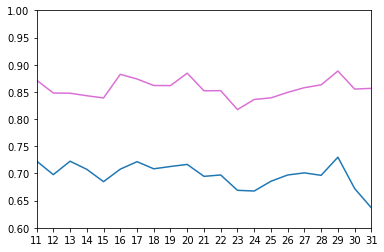

In [110]:
fig, ax = plt.subplots(1)

ax.plot(days, diy_mod)
ax.plot(days, louvain_mod, color = "orchid")
ax.set_xlim([11,31])
ax.set_xticks(days)
ax.set_ylim([0.6, 1])

# Rand Index

In [4]:
G_nx = nx.read_gml("reddit_graph_v2.gml")

In [49]:
%pip install igraph
import igraph
Gi = igraph.Graph.Read_GML("reddit_graph_v2.gml")

Note: you may need to restart the kernel to use updated packages.


In [61]:
v_diy = igraph.clustering.VertexClustering.FromAttribute(Gi, "Top_Sub")
g_truth = v_diy.membership
print("Modularity: ", v_diy.modularity)

Modularity:  0.6578766122798827


In [58]:
v_leiden = Gi.community_leiden(objective_function = "modularity", weights ="weight", n_iterations = -1)
leiden = v_leiden.membership

print("Rand Index:", metrics.rand_score(labels_true = g_truth, labels_pred=leiden))
print("Modularity:", v.modularity)

Rand Index: 0.9271846717347565
Modularity: 0.6688153818823893


In [62]:
v_louvain = Gi.community_multilevel(weights ="weight")
louvain = v_louvain.membership
print("Rand Index:", metrics.rand_score(labels_true = g_truth, labels_pred=louvain))
print("Modularity:",v_louvain.modularity)

Rand Index: 0.9218457243835322
Modularity: 0.6688631013405265


In [66]:
v_cnm = Gi.community_fastgreedy(weights = "weight").as_clustering(n = 12)
cnm = v_cnm.membership
print("Rand Index:", metrics.rand_score(labels_true = g_truth, labels_pred=cnm))
print("Modularity:", v_cnm.modularity)

Rand Index: 0.949398156263143
Modularity: 0.6690066785530212
